# Hyperparameter search analysis

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from master_scripts.data_functions import get_git_root
from master_scripts.analysis_functions import load_experiment, load_hparam_search
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Base functions for importing. To-be transferred to data_functions/analysis_functions when done

## Architecture search - kernel size
The idea is to verify that increasing the kernel size in a one-conv2d-layer network doesn't significantly increase classification performance,
or at least give an indication of that. Citing the VGG paper, it can be argued that 3x3 kernel_size is the optimal one, because you get fewer parameters
but with greater expressibility.

If the goal is to increase the size of a layer's 'field of view', the pseudo-parameter to be tuned should be the ['receptive field'](https://distill.pub/2019/computing-receptive-fields/)

In [2]:
# Load data, split on kernel size and extract only the columns we want
#df = pd.read_json("/home/ulvik/git/master_analysis/experiments/searches/architecture_search_seeded.json", orient='index')
df = load_hparam_search("architecture_search_seeded.json")
test = df.groupby(['kernel_size'])[['filters', 'dense_size','matthews_corrcoef']]
results = {}
for k in test.groups.keys():
    results[k] = test.get_group(k).pivot('filters', 'dense_size', 'matthews_corrcoef')

Text(0.5, 0.98, 'Matthews Correlation Coeffiction as a function of number of filters and size of hidden dense layer')

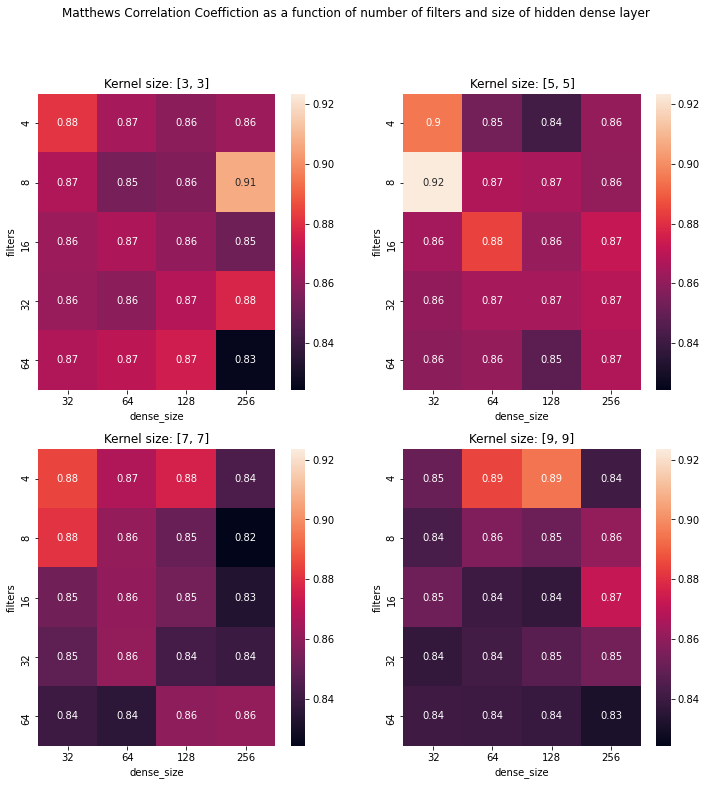

In [3]:
# Heatmap for each kernel size
# Get minimum mcc and max mcc from df to use as vmin, vmax args
vmin = df['matthews_corrcoef'].min()
vmax = df['matthews_corrcoef'].max()
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for k, ax in zip(results.keys(), axes.flatten()):
    sns.heatmap(results[k], square=True, annot=True, ax=ax, vmin=vmin, vmax=vmax)
    ax.set_title("Kernel size: " + k)
fig.suptitle("Matthews Correlation Coeffiction as a function of number of filters and size of hidden dense layer")

* no significant dependence on dense layer size.
* no significant gain in performance from increasing the kernel_size.
* number of filters also appears to not be very influential. It may be that the model is unable to fit properly well to the training data.

## Architecture search - two convolutional layers
Looking at varying number of filters in the two layers, and varying the size of the dense layer.\
Why? The single-layer model seems unable to fit very well to the training data.\
Adding more parameters in the form of
another conv layer deepens the network, increasing the expressive power of the model.

In [41]:
# Load data, split on kernel size and extract only the columns we want
#df = pd.read_json("/home/ulvik/git/master_analysis/experiments/searches/architecture_search_seeded.json", orient='index')
df_2 = load_hparam_search("architecture_search_seeded_2conv.json")
test = df_2.groupby(['dense_size'])[['l1_filters', 'l2_filters','matthews_corrcoef']]
results = {}
for k in test.groups.keys():
    results[k] = test.get_group(k).pivot('l1_filters', 'l2_filters', 'matthews_corrcoef')

display(results[32])
# results[32][4] is dense size 32, l2_filters 4 
print(results[32][4])
print(results[32][4].mean())

l2_filters,4,8,16,32,64
l1_filters,,,,,
4,0.870937,0.879452,0.885422,0.860684,0.860077
8,0.892083,0.934609,0.890835,0.808910,0.884654
16,0.861904,0.903727,0.865797,0.828525,0.846527
32,0.917974,0.856258,0.865042,0.888559,0.892401
64,0.858965,0.883794,0.905220,0.847462,0.898607


l1_filters
4     0.870937
8     0.892083
16    0.861904
32    0.917974
64    0.858965
Name: 4, dtype: float64
0.8803723565402493


Mean mcc for dense size 32: 0.8755369139193016
Mean mcc for dense size 64: 0.8770401211366099
Mean mcc for dense size 128: 0.8718975293531305
Mean mcc for dense size 256: 0.8723568119934003


Text(0.5, 0.98, 'Matthews Correlation Coeffiction as a function of number of filters in layer 1 and 2')

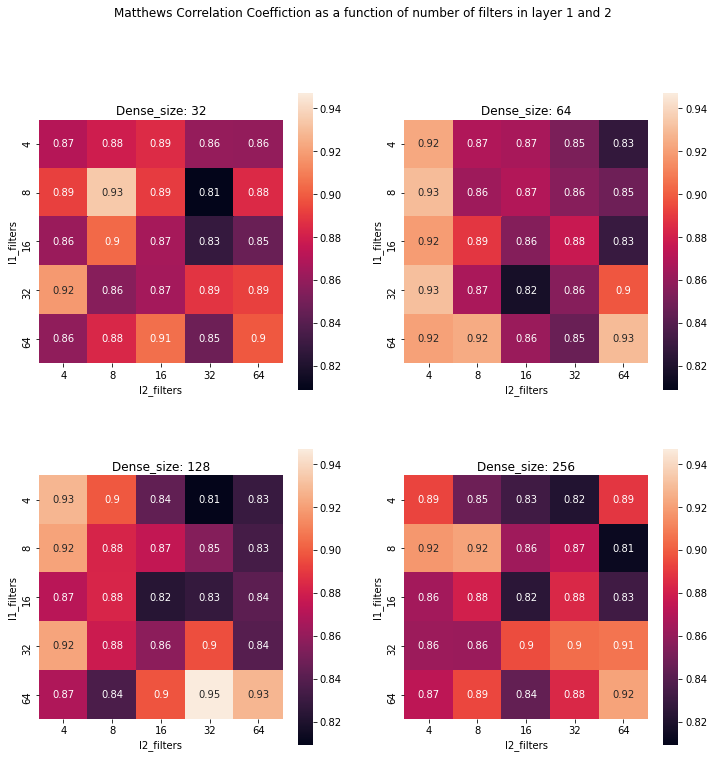

In [21]:
# Heatmap for each kernel size
# Get minimum mcc and max mcc from df to use as vmin, vmax args
vmin = df_2['matthews_corrcoef'].min()
vmax = df_2['matthews_corrcoef'].max()
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for k, ax in zip(results.keys(), axes.flatten()):
    sns.heatmap(results[k], square=True, annot=True, ax=ax, vmin=vmin, vmax=vmax)
    ax.set_title("Dense_size: " + str(k))
    print("Mean mcc for dense size {}: {}".format(str(k), np.mean(results[k].values)))
fig.suptitle("Matthews Correlation Coeffiction as a function of number of filters in layer 1 and 2")

This indicates that 64 filters in the first layer and 32 filters in the second layer may perform best.\
However, this may be just be some local optimum that we've stumbled upon. 

## Deeper architecture
Modeling the network based on existing, successful architectures.